# Quantify NN-Dynamics

In [9]:
import os
import json
import pickle
import scipy
import scipy.signal
import scipy.interpolate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
# from car_dynamics.envs.kinematic_bicycle_model import LF, LR
from car_dynamics.analysis import pos2vel_savgol, calc_delta, interpolate, rotate_point, calc_delta_v, k_step_prediction_error
from offroad.utils import load_state
import ipywidgets as widgets
from ipywidgets import interact
from termcolor import colored
import torch
from car_dynamics.models_torch import MLP, clean_random_data
from rich.progress import track
from car_dynamics.envs import make_env, KinematicBicycleModel, KinematicParams
%matplotlib inline
%load_ext autoreload
%autoreload 2

LF = .16
LR = .15
L = LF+LR
DT=0.125
# PROJ_DIR = '/Users/wenlixiao/Dropbox/School/Graduate/LeCAR/safe-learning-control/playground/offroad/'
PROJ_DIR = '/home/wenli-run/car_collect/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("DEVICE", DEVICE)

DEVICE cuda:0


In [11]:
## LOAD DATA

# log_dir = PROJ_DIR + 'data/sim-data-20240120-204829'
# log_dir = os.path.join(PROJ_DIR , 'data', 'sim-data-20240131-134617')
# t_list, p_dict, yaw_dict, action_list, controller_info = load_state(log_dir, [0, 1], orientation_provider="NONE")


log_dir = os.path.join(PROJ_DIR , 'data', 'data-20240131-184333')
t_list, p_dict, yaw_dict, action_list, controller_info = load_state(log_dir, [10,91], orientation_provider="NONE")

# log_dir = os.path.join(PROJ_DIR , 'data', 'data-20240131-195144')
# t_list, p_dict, yaw_dict, action_list, controller_info = load_state(log_dir, [10,258], orientation_provider="NONE")
obs_np = p_dict['obs']
mppi_actions = controller_info['mppi_actions']
targets = controller_info['targets']
mppi_traj = controller_info['mppi_traj']
mppi_sample_actions = controller_info['mppi_sample_actions']
is_recover = controller_info['is_recover']

In [12]:
## LOAD SIM DATA
# log_dir = '/Users/wenlixiao/Dropbox/School/Graduate/LeCAR/safe-learning-control/playground/car_dynamics/car_dynamics/tmp/circle_log.pkl'
# with open(log_dir, "rb") as f:
#     data = pickle.load(f)
# obs_np = np.array(data['obs'])
# targets = np.array(data['target'])
# mppi_actions = np.array(data['mppi_actions'])
# action_list = np.array(data['action'])
# mppi_traj = np.array(data['mppi_traj'])
# mppi_sampled_actions = np.array(data['mppi_sampled_action'])

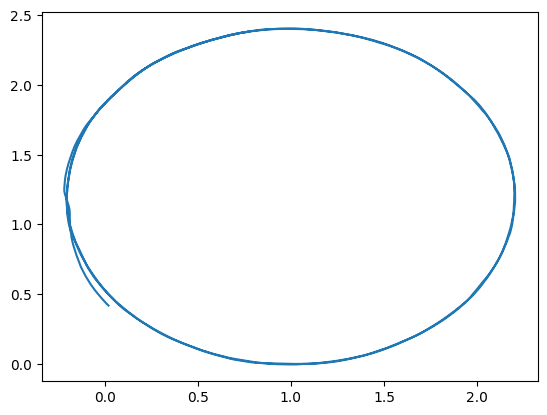

In [13]:
plt.plot(obs_np[:, 0], obs_np[:, 1])
# plt.plot(targets[:, 0, 0], targets[:, 0, 1])

## Quantify Pred Error

In [21]:

model_list = [
                # ('20240129-015345', 2, 256, 'nn-end2end', 'real\nend2end6'),
                  # ('20240131-142206', 2, 64, 'nn-end2end', 'sim\nend2end'),
                  # ('20240131-155022', 8, 32, 'nn-end2end', 'real\nend2end'),
                  # ('20240131-165751', 8, 32, 'nn-end2end', 'mix\nend2end'),
                  ('', 1, 0, 'kbm', 'kbm'),
                  ('20240212-101637', 2, 128, 'nn-end2end', 'mix/nend2end'),
                  # ('20240202-140513', 4, 32, 'nn-phyx-kbm', 'sim\nphyx-kbm'),
                  # ('20240202-141435', 4, 32, 'nn-phyx-kbm', 'real\nphyx-kbm'),
                  
]

(806, 5, 4)
(805, 6, 4)


Text(0.5, 0.98, 'Evaluation on Real Data')

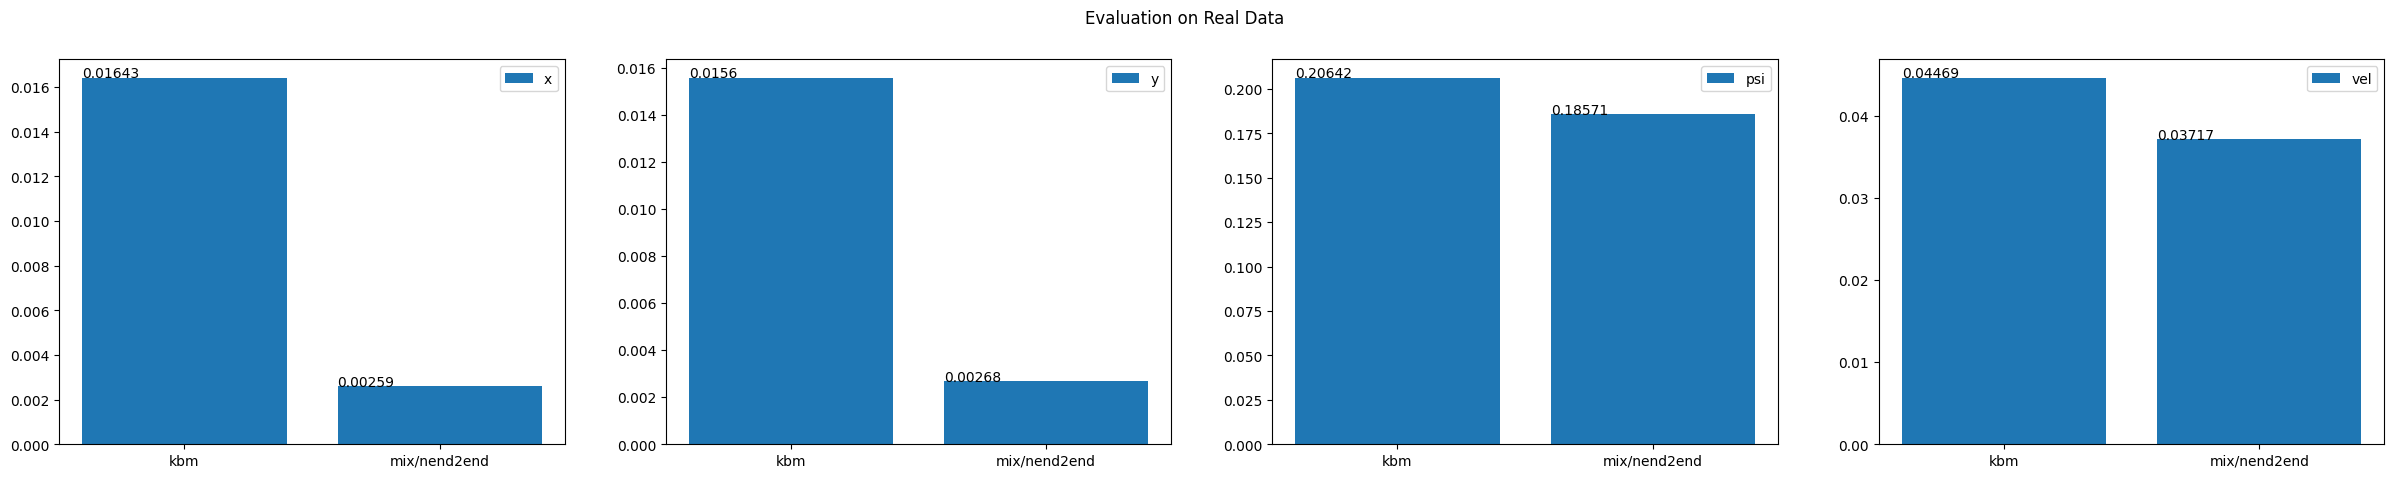

In [26]:
obs_np_copy = obs_np.copy()
action_list_copy = action_list.copy()
is_recover_copy = is_recover.copy()

ae_err = []
mae_err = []
xlabels = []
traj_list = []
ground_truth_traj_list = []
obs_diff = []
for i, (model_path, H, hidden_dim, model_struct, remark) in enumerate(model_list):
    K=4
    DT = 0.05
    model_dir = os.path.join(PROJ_DIR, "tmp", model_path, "model.pt")
    # print(model_path)
    if model_struct == 'nn-end2end':
        model = MLP(input_size=6*H, hidden_size=hidden_dim, output_size=4)
        model.load(model_dir)
        model.to(DEVICE)
    if model_struct == 'nn-end2end-trunk':
        model = MLP(input_size=7*H, hidden_size=hidden_dim, output_size=4)
        model.load(model_dir)
        model.to(DEVICE)
    elif model_struct == 'nn-heading':
        model = MLP(input_size=6*H, hidden_size=hidden_dim, output_size=3)
        model.load(model_dir)
        model.to(DEVICE)
    elif model_struct == 'nn-heading-psi':
        model = MLP(input_size=6*H, hidden_size=hidden_dim, output_size=5)
        model.load(model_dir)
        model.to(DEVICE)
    elif model_struct == 'nn-phyx-kbm':
        model = MLP(input_size=7*H-2, hidden_size=hidden_dim, output_size=2)
        model.load(model_dir)
        model.to(DEVICE)
        
    state_clean = clean_random_data(obs_np_copy, action_list_copy, is_recover_copy,H + K)
    # state_clean = [(obs_np_copy, action_list_copy)]
    ae_err_all = []
    obs_all = []
    traj_all = []
    ground_truth_traj_all = []
    # print(state_clean)
    for obs_clean, action_clean in state_clean:
        obs_clean = np.array(obs_clean)
        action_clean = np.array(action_clean)
        # print(obs_clean.shape, action_clean.shape)
        if model_struct == 'kbm':
            N_ROLLOUTS = len(obs_clean) - (H+K-1)
            model_params = KinematicParams(
                        num_envs=N_ROLLOUTS,
                        last_diff_vel=torch.zeros([N_ROLLOUTS, 1]).to(DEVICE), KP_VEL=5.96, KD_VEL=0.02, MAX_VEL=5., PROJ_STEER=-0.03, SHIFT_STEER=0.38, DT=DT, #real
            )  
            model = KinematicBicycleModel(model_params, device=DEVICE)
        obs_all += obs_clean.tolist()
        
        error_dict, pred_info = k_step_prediction_error(model, obs_clean, action_clean, H, K, DEVICE, model_struct, DT, L, LR, normalize_pos=True)
        print(pred_info['pred_k_trajectory'].shape)
        ae_err_all += error_dict["ae"].tolist()
        traj_all += pred_info['pred_k_trajectory'].tolist()
        ground_truth_traj_all += pred_info['batch_slice_obs'].tolist()
    
    ae_err.append(np.array(ae_err_all))
    traj_list.append(np.array(traj_all))
    ground_truth_traj_list.append(np.array(ground_truth_traj_all))
    # traj_list.append(pred_info['pred_k_trajectory'])
    # ground_truth_traj_list.append(pred_info['batch_slice_obs'])
    xlabels.append(remark)
    mae_err.append(np.mean(ae_err_all, axis=0))
    
    obs_diff.append(np.array(obs_all))
    
fig, axs = plt.subplots(1,4,figsize=(30,5))
mae_err = np.array(mae_err)
labels=['x','y','psi','vel']
# print(mae_err.shape)
for i in range(4):
    bars = axs[i].bar(xlabels,mae_err[:, i], label=labels[i])
    axs[i].legend()
    for bar in bars:
        axs[i].text(bar.get_x(), bar.get_height(), np.round(bar.get_height(), 5))
    # axs[i].set_yscale("log")

plt.suptitle("Evaluation on Real Data")

Text(0.5, 0.98, 'Error Distribution in Real Data')

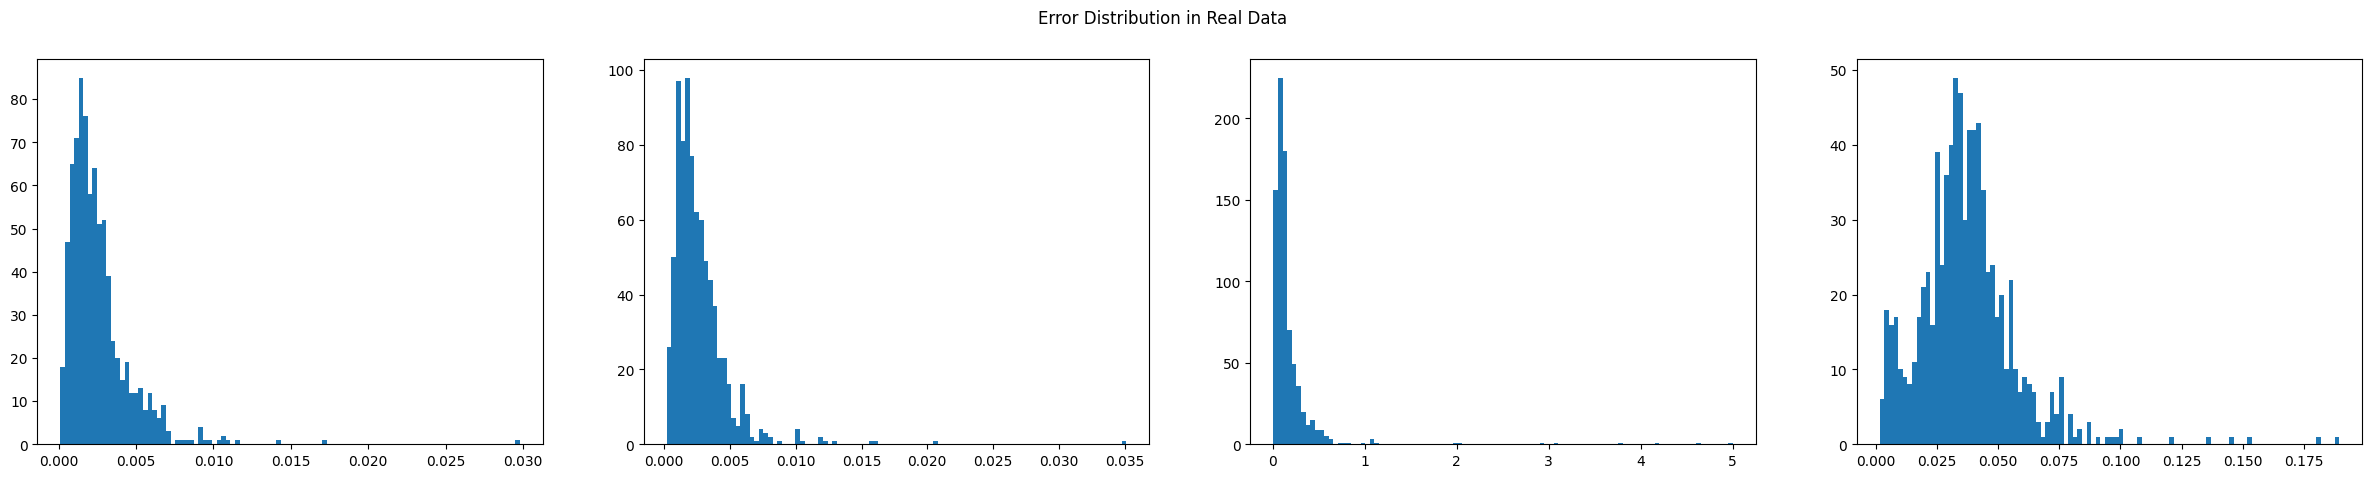

In [27]:
err_idx = 1
fig, axs = plt.subplots(1,4,figsize=(30,5))
axs[0].hist(ae_err[err_idx][:, 0], bins=100)
axs[1].hist(ae_err[err_idx][:, 1], bins=100)
axs[2].hist(ae_err[err_idx][:, 2], bins=100)
axs[3].hist(ae_err[err_idx][:, 3], bins=100)
# plt.yscale('symlog')
# axs[0].set_xscale('symlog')
# axs[1].set_xscale('symlog')
# axs[2].set_xscale('symlog')
# axs[3].set_xscale('symlog')
plt.suptitle("Error Distribution in Real Data")

## Plot pred trajectory

interactive(children=(IntSlider(value=74, description='N', max=810), Checkbox(value=False, description='vis_wp…

<function __main__.plot(N=74, vis_wp=False)>

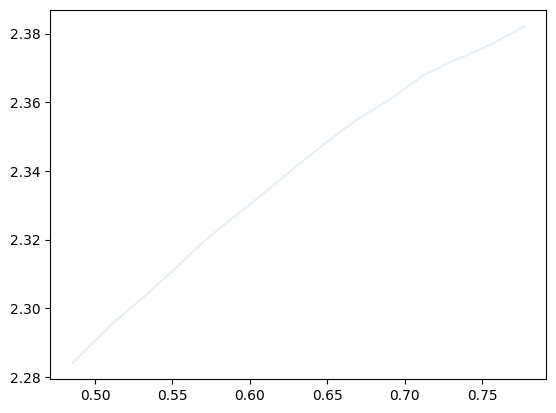

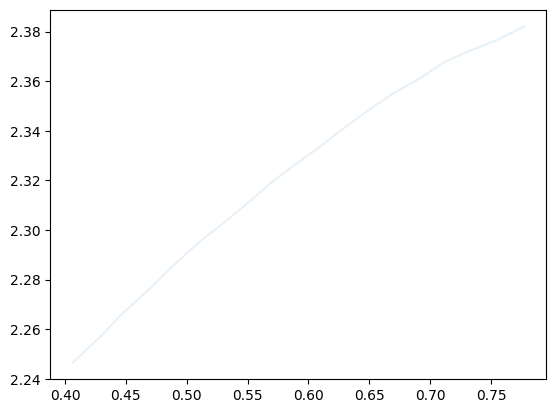

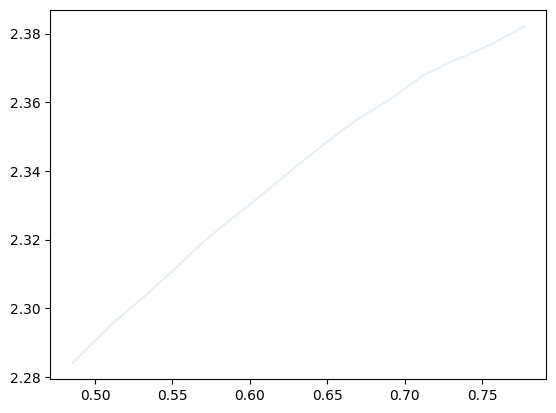

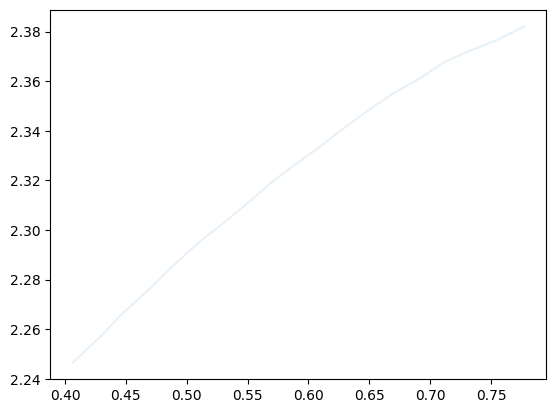

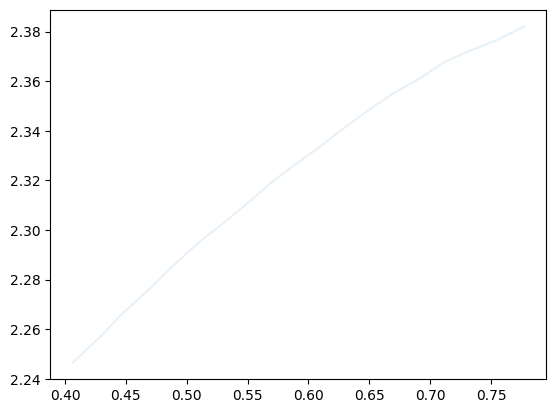

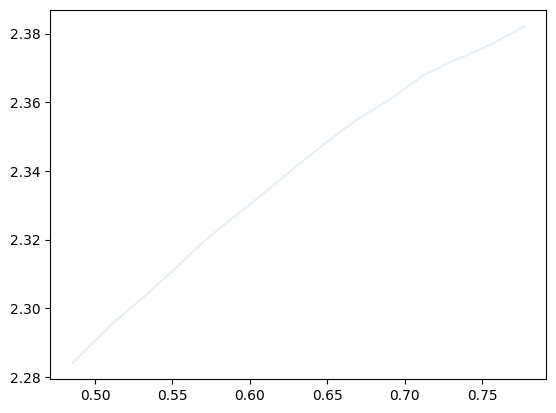

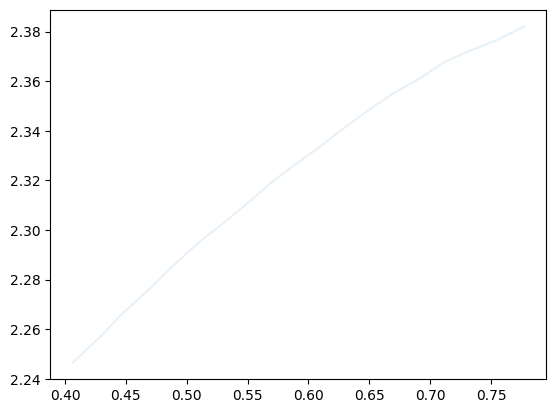

In [28]:
def plot(N=74, vis_wp=False,):
    # plt.figure(figsize=(10,10))
    # plt.plot(obs_np[:, 0], obs_np[:, 1], alpha = 0.1)
    plt.plot(obs_np_copy[max(0,N-15):N+20, 0], obs_np_copy[max(0,N-15):N+20, 1], alpha = 0.1)
    # plt.plot(obs_np_copy[N:N+K+1, 0], obs_np_copy[N:N+K+1, 1], c='red', label='ground truth', marker='o')
    for i, traj in enumerate(traj_list):
        H = traj.shape[1] - K
        # plt.plot(traj[N+1-H, H-1:, 0], traj[N+1-H, H-1:, 1], label=xlabels[i], marker='x', alpha=0.5)
        plt.plot(traj[N+1-H, H-1:, 0], traj[N+1-H, H-1:, 1], label=xlabels[i], marker='x', alpha=0.5)
    plt.legend()
interact(
    plot,
    N=(0, obs_np_copy.shape[0], 1),
)